# Práctica 2: Regresion Logística

Alumnos: Andrés Ruiz Bartolomé y Adrián de Lucas Gómez  

In [6]:
import numpy as np
from numpy.lib import math
from pandas.io.parsers import read_csv
from matplotlib import pyplot as plt
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures

## 1.1- Visualización de los datos

Para obtener los datos de los casos de prueba usaremos la funcion read_csv dada por **panda**. Por medio de operaciones sobre el vector original obtenemos el vector de los aprobados y de los suspensos, admitidos y sus respectivamente. Los ponemos en la grafica con **scatter** y cada tipo con un simbolo distinto.

Para el calculo de la recta que separe ambos conjuntos deberemos de usar nuestros métodos de coste y gradiente en la función **fmin_tnc** que nos dará la theta optima. Con eso y las notas del examen podemos calcular la recta en el método **pinta_frontera_recta**

[-25.16131842   0.20623159   0.20147148]
porcentaje de casos predichos correctmente 89.0%


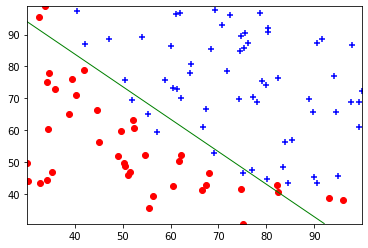

In [11]:
def primeraParte():

	valores = read_csv("ex2data1.csv", header = None).to_numpy()

	admitidos = np.where(valores[:,2] == 0)
	sus = np.where(valores[:,2] == 1)
	plt.scatter(valores[admitidos,0], valores[admitidos,1], marker='o',c='red')
	plt.scatter(valores[sus,0], valores[sus,1], marker='+',c='blue')


	X = valores[:,:-1]
	Y = valores[:,-1]
	m = np.shape(X)[0]
	n = np.shape(X)[1]
	X = np.hstack([np.ones([m, 1]),X])

	theta = np.zeros(np.shape(X)[1])

	result = opt.fmin_tnc(func = coste, x0 = theta, fprime = gradiente, args = (X,Y))
	theta_opt = result[0]
	print(theta_opt)

	pinta_frontera_recta(X, Y , theta_opt)

	evaluaLogistica(X,Y, theta_opt)

	plt.show()
	plt.close()

def pinta_frontera_recta(X, Y, theta):
	x1_min, x1_max = X[:, 1].min(), X[:, 1].max()
	x2_min, x2_max = X[:, 2].min(), X[:, 2].max()

	xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max),
	np.linspace(x2_min, x2_max))

	h = sigmoide(np.c_[np.ones((xx1.ravel().shape[0], 1)),
	xx1.ravel(),
	xx2.ravel()].dot(theta))
	h = h.reshape(xx1.shape)

	# el cuarto parámetro es el valor de z cuya frontera se
	# quiere pintar
	plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='green')

primeraParte()

## 1.2-1.3 Funcion sigmoide, coste y gradiente

Estas son las funciones que usamos en el método principal. La funcion sigmoide es la que se encarga de dado un valor determinar si esa nota pertenece a los aprobados o no, es decir , si es 0 o 1. Con esto podemos calcular el coste para cada punto y con ello hacer el gradiente para acabar hallando el theta optimo. Los tres métodos son vectorizados por lo que son mas eficientes.

In [8]:
def sigmoide(a):
	r = 1 / (1+ np.exp(-a))  
	return r

def coste(theta, X, Y):

	H = sigmoide(np.matmul(X, theta))

	cost = (-1/(len(X))) * (np.dot(Y, np.log(H)) +
							np.dot((1-Y), np.log(1-H)))

	return cost

def gradiente(theta,XT, Y):
	H = sigmoide(np.matmul(XT, theta))

	grad = (1/len(Y)) * np.matmul(XT.T, H - Y)
	return grad

## 1.5- Evaluación de la regresión logística

Esta evaluación se encarga de decirnos como de precisa ha sido la predicción sobre los aprobados y suspensos de los casos de prueba teniendop en cuenta los casos en los que no se corresponde la realidad con la predicción dada por la función. Con los casos de prueba daba una precisión del 89%.

In [10]:
def evaluaLogistica(X,Y,theta):
	b = sigmoide( np.dot(X,theta))>=0.5
	correctos = np.sum((sigmoide( np.dot(X,theta))>=0.5)==Y)
	print(f"porcentaje de casos predichos correctmente {correctos / np.shape(X)[0] * 100}%")

## 2.0- Regresión logística regularizada

En este segundo apartado se nos presenta la tarea de volver a dividir por una frontera 2 conjuntos distintos. El problema es que no pueden ser separados por una recta, por ello deberemos recorrer a funciones con mayor número de polinomios dando como resultado una curva que separe lo mejor posible los 2 conjuntos.

Tras colocar de nuevo los puntos en pantalla deberemos de calcular la theta optima pero esta vez usando versiones regularizadas del coste y el gradiente.

Ya con la theta óptima y el parametro regulador lambda podremos dibujar en pantalla la curva que separa de la mejor forma posible esos conjuntos. Esta curva es una curva de nivel a altura 0.5 de la sigmoide. En la imagen podemos ver como actuan 5 valores distintos de lambda sobre la curva. Con lambda 0 la curva no llega ni a cerrarse intentando ajustarse a los casos concretos que usamos, mientras que con lambda 4 generaliza mucho más la separación.

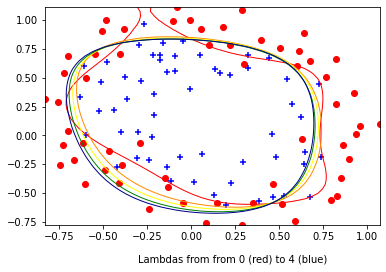

In [24]:
def parte2():
	plt.figure()
	valores = read_csv("ex2data2.csv", header = None).to_numpy()

	admitidos = np.where(valores[:,2] == 0)
	sus = np.where(valores[:,2] == 1)
	plt.scatter(valores[admitidos,0], valores[admitidos,1], marker='o',c='red')
	plt.scatter(valores[sus,0], valores[sus,1], marker='+',c='blue')

	X = valores[:,:-1]
	Y = valores[:,-1]
	m = np.shape(X)[0]
	n = np.shape(X)[1]

	poly = PolynomialFeatures(6)
	x_ft= poly.fit_transform(X)
	theta = np.zeros(np.shape(x_ft)[1])

	ini = 0
	fin = 4
	lambditas = np.linspace(ini,fin,5)

	colorines = ["red", "darkorange", "yellow", "green", "darkblue"]

	for l, col in zip(lambditas,colorines):
		result = opt.fmin_tnc(func = costeRegularizado, x0 = theta, fprime = gradienteRegularizado, args = (x_ft,Y,l))
		theta_opt = result[0]
		plot_decisionboundary(X,Y,theta_opt,poly, l, col)

	plt.text(-0.3,-1.1,("Lambdas from from {0} (red) to {1} (blue)".format(ini,fin) ))
	plt.show()

def plot_decisionboundary(X, Y, theta, poly, lanbda,color):
	x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
	x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
	xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max),
	np.linspace(x2_min, x2_max))
	h = sigmoide(poly.fit_transform(np.c_[xx1.ravel(),
	xx2.ravel()]).dot(theta))
	h = h.reshape(xx1.shape)
	plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors=color)

parte2()

## 2.2- Cálculo de la función de coste y su gradiente

La diferencia de esta funcion de coste y gradiente con la no regularizada es el inclusion de las expresiones ((lambda/2*(len(X))*(theta**2).sum())) y (lambda/2*(len(XT)*theta)). El objetivo de esas funciones es el de regularizar el valor de las funciones por medio de lambda el cual podremos modificar para ajustar en mayor o menor medida la curva que separará los conjuntos. Como en el gradiente la primera componente nos interesa que siga siendo la misma la copiamos del gradiente original y se la ponemos en la versión regularizada.

In [ ]:
def costeRegularizado(theta, X, Y, lambo):
	m = np.shape(X)[0]
	return coste(theta, X, Y ) + lambo * np.sum(theta**2)/(2*m)

def gradienteRegularizado(theta,XT, Y, lambo):
	grad = (gradiente(theta,XT, Y))
	a = grad[0]
	reg = lambo*theta / len(Y)
	reg[0] = a
	return grad + reg 